The KDD cup was an International Knowledge Discovery and Data Mining Tools Competition. In 1999, this competition was held with the goal of collecting traffic records. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. As a result of this competition, a mass amount of internet traffic records were collected and bundled into a data set called the KDD’99, and from this, the NSL-KDD data set was brought into existence, as a revised, cleaned-up version of the KDD’99 from the University of New Brunswick.
https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657

In [1]:
#!/usr/bin/env python
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
train_data = pd.read_csv('Train_data.csv')
test_data = pd.read_csv('Test_data.csv')

In [3]:
# Two additional DataFrames, train_data_df and test_data_df, are created to hold the train and test data, respectively.
# The shapes of these DataFrames are printed using the shape attribute to get an idea of the number of rows and columns
# in each DataFrame.
train_data_df = pd.DataFrame(train_data)
print(train_data_df.shape)

(25192, 42)


In [4]:
test_data_df = pd.DataFrame(test_data)
print(test_data_df.shape)

(22544, 41)


In [5]:
# Since the feature sets of these two datas are different, I need to figure out why.
set(train_data_df).difference(set(test_data_df))

{'class'}

In [6]:
# The columns of the train_data_df DataFrame are printed using the head() function to examine the first five rows.
train_data_df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [7]:
# Choose feature set to use
"""
# 10 best features from Chi Squared Feature Selection + 'class'
train_data_df = train_data_df[['logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'class']]
"""
"""
# 15 best features from Chi Squared Feature Selection + 'class'
train_data_df = train_data_df[['flag', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class']]
"""
#"""
# 20 best features from Chi Squared Feature Selection + 'class'
train_data_df = train_data_df[['service', 'flag', 'wrong_fragment', 'logged_in', 'count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class']]
#"""

In [8]:
# Provide information such as count, mean, standard deviation, minimum, quartiles, and maximum values for each column.
train_data_df.describe()

,wrong_fragment,logged_in,count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,0.023738,0.394768,84.591180,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.285800,0.279846,0.117800,0.118769
std,0.260221,0.488811,114.673451,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,144.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,1.000000,1.000000,0.000000,0.000000
max,3.000000,1.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
train_data_df['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

| field | continuous vs discrete | example |
| --- | --- | --- |
| duration | continuous | |
| protocol_type | discrete | tcp, udp, icmp |
| service | discrete | 66 values including http, private, domain_u, smtp, ftp_data, and so forth. |
| flag | discrete | 11 values including SF, S0, REJ, RSTR, and so forth. |
| src_bytes | continuous | |
| dst_bytes | continuous | |
| class | discrete | normal vs anomaly |

# Feature Engineering

## protocol_type

In [10]:
# print(train_data_df.protocol_type.unique())

In [11]:
"""
# convert protocol_type column to numerical values
for i in range(len(train_data_df.protocol_type)):
    if train_data_df.protocol_type[i] == 'tcp':
        train_data_df.loc[i, "protocol_type_n"] = 0
        continue

    if train_data_df.protocol_type[i] == 'udp':
        train_data_df.loc[i, "protocol_type_n"] = 1
        continue

    if train_data_df.protocol_type[i] == 'icmp':
        train_data_df.loc[i, "protocol_type_n"] = 2
        continue
"""

'\n# convert protocol_type column to numerical values\nfor i in range(len(train_data_df.protocol_type)):\n    if train_data_df.protocol_type[i] == \'tcp\':\n        train_data_df.loc[i, "protocol_type_n"] = 0\n        continue\n\n    if train_data_df.protocol_type[i] == \'udp\':\n        train_data_df.loc[i, "protocol_type_n"] = 1\n        continue\n\n    if train_data_df.protocol_type[i] == \'icmp\':\n        train_data_df.loc[i, "protocol_type_n"] = 2\n        continue\n'

In [12]:
# train_data_df.protocol_type_n.unique()

## service

In [13]:
print(train_data_df.service.unique())

['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']


In [14]:
#"""
# A dictionary service_d is created to map each unique value to a numerical ID.
service_d = {}
id = 0
for ft in train_data_df.service:
    if ft not in service_d:
        service_d[ft] = id
        id += 1
print(service_d)
#"""

{'ftp_data': 0, 'other': 1, 'private': 2, 'http': 3, 'remote_job': 4, 'name': 5, 'netbios_ns': 6, 'eco_i': 7, 'mtp': 8, 'telnet': 9, 'finger': 10, 'domain_u': 11, 'supdup': 12, 'uucp_path': 13, 'Z39_50': 14, 'smtp': 15, 'csnet_ns': 16, 'uucp': 17, 'netbios_dgm': 18, 'urp_i': 19, 'auth': 20, 'domain': 21, 'ftp': 22, 'bgp': 23, 'ldap': 24, 'ecr_i': 25, 'gopher': 26, 'vmnet': 27, 'systat': 28, 'http_443': 29, 'efs': 30, 'whois': 31, 'imap4': 32, 'iso_tsap': 33, 'echo': 34, 'klogin': 35, 'link': 36, 'sunrpc': 37, 'login': 38, 'kshell': 39, 'sql_net': 40, 'time': 41, 'hostnames': 42, 'exec': 43, 'ntp_u': 44, 'discard': 45, 'nntp': 46, 'courier': 47, 'ctf': 48, 'ssh': 49, 'daytime': 50, 'shell': 51, 'netstat': 52, 'pop_3': 53, 'nnsp': 54, 'IRC': 55, 'pop_2': 56, 'printer': 57, 'tim_i': 58, 'pm_dump': 59, 'red_i': 60, 'netbios_ssn': 61, 'rje': 62, 'X11': 63, 'urh_i': 64, 'http_8001': 65}


In [15]:
#"""
# A loop iterates over the rows of the DataFrame, maps each value to its corresponding ID,
# and stores the result in a new column named 'service_n'.
for i, e in enumerate(train_data.service):
    train_data_df.loc[i, "service_n"] = service_d[e]
    # I am iterating over the service column again. For each value,
    # I find its corresponding numerical ID in the service_d dictionary,
    # and I assign this numerical ID to the new column service_n.
#"""

 While it might seem that both pieces of the below code blocks are doing the same thing, they actually have different purposes. The first code block creates a mapping from unique categorical values to unique numerical IDs, and the second one uses this mapping to transform the categorical values into numerical ones. Both steps are necessary in the process of transforming categorical data into a numerical format that can be used by machine learning algorithms.

In [16]:
train_data_df.service_n.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65.])

## flag

In [17]:
print(train_data_df.flag.unique())

['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']


In [18]:
#"""
flag_d = {}
id = 0
for ft in train_data_df.flag:
    if ft not in flag_d:
        flag_d[ft] = id
        id += 1
#"""

In [19]:
#"""
for i, e in enumerate(train_data_df.flag):
    train_data_df.loc[i, "flag_n"] = flag_d[e]
#"""

In [20]:
train_data_df.flag_n.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

## class

In [21]:
# A loop iterates over the rows, mapping 'normal' to 0 and 'anomaly' to 1,
# and stores the result in a new column named 'class_n'.
for i in range(len(train_data)):
    if train_data_df['class'][i] == 'normal':
        train_data_df.loc[i, 'class_n'] = 0

    if train_data_df['class'][i] == 'anomaly':
        train_data_df.loc[i, 'class_n'] = 1

# train-to-test split

In [22]:
# Calculates the index corresponding to 80% of the rows in the DataFrame (eighty_cut_n)
# and creates separate DataFrames for training and testing
eighty_cut_n = math.ceil(train_data_df.shape[0] * 0.8)
print(eighty_cut_n)

20154


In [23]:
train_data_df.head()

,service,flag,wrong_fragment,logged_in,count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,service_n,flag_n,class_n
0,ftp_data,SF,0,0,2,0.0,0.0,0.0,0.0,1.00,...,0.17,0.03,0.00,0.00,0.05,0.00,normal,0.0,0.0,0.0
1,other,SF,0,0,13,0.0,0.0,0.0,0.0,0.08,...,0.00,0.60,0.00,0.00,0.00,0.00,normal,1.0,0.0,0.0
2,private,S0,0,0,123,1.0,1.0,0.0,0.0,0.05,...,0.10,0.05,1.00,1.00,0.00,0.00,anomaly,2.0,1.0,1.0
3,http,SF,0,1,5,0.2,0.2,0.0,0.0,1.00,...,1.00,0.00,0.03,0.01,0.00,0.01,normal,3.0,0.0,0.0
4,http,SF,0,1,30,0.0,0.0,0.0,0.0,1.00,...,1.00,0.00,0.00,0.00,0.00,0.00,normal,3.0,0.0,0.0


In [24]:
# 10 best features from Chi Squared Feature Selection
"""
train_x = train_data_df.loc[:eighty_cut_n, ['logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate']]
train_y = train_data_df.loc[:eighty_cut_n, 'class_n']
test_x = train_data_df.loc[eighty_cut_n:, ['logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate']]
test_y = train_data_df.loc[eighty_cut_n:, 'class_n']
"""

"\ntrain_x = train_data_df.loc[:eighty_cut_n, ['logged_in', 'count', 'serror_rate', 'srv_serror_rate',\n       'srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_count',\n       'dst_host_same_srv_rate', 'dst_host_serror_rate',\n       'dst_host_srv_serror_rate']]\ntrain_y = train_data_df.loc[:eighty_cut_n, 'class_n']\ntest_x = train_data_df.loc[eighty_cut_n:, ['logged_in', 'count', 'serror_rate', 'srv_serror_rate',\n       'srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_count',\n       'dst_host_same_srv_rate', 'dst_host_serror_rate',\n       'dst_host_srv_serror_rate']]\ntest_y = train_data_df.loc[eighty_cut_n:, 'class_n']\n"

In [25]:
# 15 best features from Chi Squared Feature Selection
"""
train_x = train_data_df.loc[:eighty_cut_n, ['flag_n', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']]
train_y = train_data_df.loc[:eighty_cut_n, 'class_n']
test_x = train_data_df.loc[eighty_cut_n:, ['flag_n', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']]
test_y = train_data_df.loc[eighty_cut_n:, 'class_n']
"""

"\ntrain_x = train_data_df.loc[:eighty_cut_n, ['flag_n', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate',\n       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_count',\n       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',\n       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',\n       'dst_host_srv_rerror_rate']]\ntrain_y = train_data_df.loc[:eighty_cut_n, 'class_n']\ntest_x = train_data_df.loc[eighty_cut_n:, ['flag_n', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate',\n       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'dst_host_count',\n       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',\n       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',\n       'dst_host_srv_rerror_rate']]\ntest_y = train_data_df.loc[eighty_cut_n:, 'class_n']\n"

In [26]:
# 20 best features from Chi Squared Feature Selection
#"""
train_x = train_data_df.loc[:eighty_cut_n, ['service_n', 'flag_n', 'wrong_fragment', 'logged_in', 'count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']]
train_y = train_data_df.loc[:eighty_cut_n, 'class_n']
test_x = train_data_df.loc[eighty_cut_n:, ['service_n', 'flag_n', 'wrong_fragment', 'logged_in', 'count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']]
test_y = train_data_df.loc[eighty_cut_n:, 'class_n']
#"""

In [27]:
train_data.shape

(25192, 42)

In [28]:
train_x.shape

(20155, 20)

In [29]:
test_x.shape

(5038, 20)

In [30]:
train_y.value_counts()

0.0    10775
1.0     9380
Name: class_n, dtype: int64

Text(0, 0.5, 'Frequency')

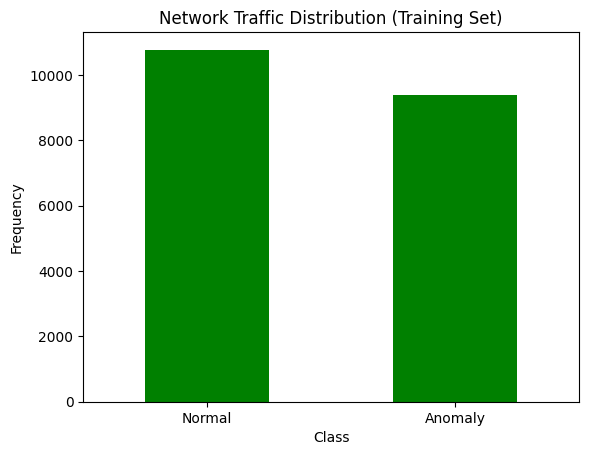

In [31]:
label_l = ['Normal', 'Anomaly']
classes = pd.value_counts(train_y, sort = True)
classes.plot(kind = 'bar', rot = 0, color = "green")
plt.title("Network Traffic Distribution (Training Set)")
plt.xticks(range(2), label_l)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [32]:
test_y.value_counts()

0.0    2675
1.0    2363
Name: class_n, dtype: int64

Text(0, 0.5, 'Frequency')

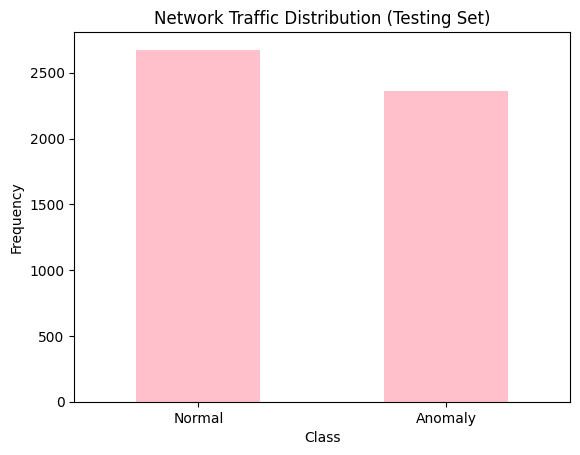

In [33]:
labels = ['Normal', 'Anomaly']
classes = pd.value_counts(test_y, sort = True)
classes.plot(kind = 'bar', rot = 0, color = "pink")
plt.title("Network Traffic Distribution (Testing Set)")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [34]:
train_x.isnull().any().sum()

0

In [35]:
train_y.isnull().any().sum()

0

In [36]:
test_x.isnull().any().sum()

0

In [37]:
test_y.isnull().any().sum()

0

# Modeling

## Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
# param_grid = {'C': np.logspace(-3,3,7), 'penalty': ['l1','l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
# lr_grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, verbose=2, n_jobs=-1)
# nslkdd_lr_clf = lr_grid_search.fit(train_x, train_y)

In [40]:
# lr_grid_search.best_params_

In [41]:
# lr_grid_search.best_score_

In [42]:
nslkdd_lr_clf = LogisticRegression(C=100, penalty='l1', solver='liblinear').fit(train_x, train_y)

In [43]:
pred_test_y = nslkdd_lr_clf.predict(test_x)
print(pred_test_y)

[0. 0. 0. ... 1. 1. 1.]


In [44]:
accuracy_score(test_y, pred_test_y)

0.9364827312425565

In [45]:
confusion_matrix(test_y, pred_test_y)

array([[2575,  100],
       [ 220, 2143]])

In [46]:
tn, fp, fn, tp = confusion_matrix(test_y, pred_test_y).ravel()
print(f"accuracy is {(tp +tn)/(tn+fp+fn+tp)}")
print(f"precision is {tp / (tp + fp)}")
print(f"recall is {tp / (tp + fn)}")

accuracy is 0.9364827312425565
precision is 0.9554168524297816
recall is 0.9068980110029623


In [47]:
f1_score(test_y, pred_test_y, average='macro')

0.9360122437866196

## Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
# param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,8,10,12], 'min_samples_split': [2,4,6,8,10,12]}
# dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, verbose=2, n_jobs=-1)
# nslkdd_dt_clf = dt_grid_search.fit(train_x, train_y)

In [50]:
# dt_grid_search.best_params_

In [51]:
# dt_grid_search.best_score_

In [52]:
nslkdd_dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_split=10).fit(train_x, train_y)

In [53]:
pred_test_y = nslkdd_dt_clf.predict(test_x)
print(pred_test_y)

[0. 0. 0. ... 1. 1. 1.]


In [54]:
accuracy_score(test_y, pred_test_y)

0.9890829694323144

In [55]:
confusion_matrix(test_y, pred_test_y)

array([[2650,   25],
       [  30, 2333]])

In [56]:
tn, fp, fn, tp = confusion_matrix(test_y, pred_test_y).ravel()
print(f"accuracy is {(tp +tn)/(tn+fp+fn+tp)}")
print(f"precision is {tp / (tp + fp)}")
print(f"recall is {tp / (tp + fn)}")

accuracy is 0.9890829694323144
precision is 0.9893977947413062
recall is 0.9873042742276766


In [57]:
f1_score(test_y, pred_test_y, average='macro')

0.9890395754432535

## Random Forest


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
nslkdd_rf_clf = RandomForestClassifier(max_depth = 10).fit(train_x, train_y)

In [60]:
pred_test_y = nslkdd_rf_clf.predict(test_x)
print(pred_test_y)

[0. 0. 0. ... 1. 1. 1.]


In [61]:
accuracy_score(test_y, pred_test_y)

0.9894799523620484

In [62]:
confusion_matrix(test_y, pred_test_y)

array([[2667,    8],
       [  45, 2318]])

In [63]:
tn, fp, fn, tp = confusion_matrix(test_y, pred_test_y).ravel()
print(f"accuracy is {(tp +tn)/(tn+fp+fn+tp)}")
print(f"precision is {tp/(tp + fp)}")
print(f"recall is {tp/(tp + fn)}")

accuracy is 0.9894799523620484
precision is 0.9965606190885641
recall is 0.980956411341515


In [64]:
f1_score(test_y, pred_test_y, average='macro')

0.9894292251082091

## K-Nearest Neighbors

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
# param_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 'weights': ['uniform', 'distance']}
# knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, verbose=2, n_jobs=-1)
# nslkdd_knn_clf = knn_grid_search.fit(train_x, train_y)

In [67]:
# knn_grid_search.best_params_

In [68]:
# knn_grid_search.best_score_

In [69]:
nslkdd_knn_clf = KNeighborsClassifier(n_neighbors=8, weights='distance').fit(train_x, train_y)

In [70]:
pred_test_y = nslkdd_knn_clf.predict(test_x)
print(pred_test_y)

[0. 0. 0. ... 1. 1. 1.]


In [71]:
accuracy_score(test_y, pred_test_y)

0.9686383485510123

In [72]:
confusion_matrix(test_y, pred_test_y)

array([[2597,   78],
       [  80, 2283]])

In [73]:
tn, fp, fn, tp = confusion_matrix(test_y, pred_test_y).ravel()
print(f"accuracy is {(tp +tn)/(tn+fp+fn+tp)}")
print(f"precision is {tp / (tp + fp)}")
print(f"recall is {tp / (tp + fn)}")

accuracy is 0.9686383485510123
precision is 0.9669631512071156
recall is 0.9661447312738045


In [74]:
f1_score(test_y, pred_test_y, average='macro')

0.968516046926359

## SVM

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [75]:
from sklearn import svm

In [76]:
# param_grid = {'gamma': [0.1, 1.0, 10, 100], 'C': [0.1, 1.0, 10, 100]}
# svm_grid_search = GridSearchCV(svm.SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)
# nslkdd_svm_clf = svm_grid_search.fit(train_x, train_y)

In [77]:
# svm_grid_search.best_params_

In [78]:
# svm_grid_search.best_score_

In [79]:
nslkdd_svm_clf = svm.SVC(gamma=0.1, C=100).fit(train_x, train_y)

In [80]:
pred_test_y = nslkdd_svm_clf.predict(test_x)
print(pred_test_y)

[0. 0. 0. ... 1. 1. 1.]


In [81]:
accuracy_score(test_y, pred_test_y)

0.9660579595077412

In [82]:
confusion_matrix(test_y, pred_test_y)

array([[2618,   57],
       [ 114, 2249]])

In [83]:
tn, fp, fn, tp = confusion_matrix(test_y, pred_test_y).ravel()
print(f"accuracy is {(tp +tn)/(tn+fp+fn+tp)}")
print(f"precision is {tp / (tp + fp)}")
print(f"recall is {tp / (tp + fn)}")

accuracy is 0.9660579595077412
precision is 0.9752818733738075
recall is 0.9517562420651714


In [84]:
f1_score(test_y, pred_test_y, average='macro')

0.9658748923511771